In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-05-04 21:57:55.525989: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-05-04 21:57:57.353966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 21:57:57.384712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 21:57:57.384931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
L = 1
m = 1
omega = 0.5

In [3]:
num_dense_nodes = 20
num_dense_layers = 5

In [4]:
nx = 2
ny = 1

In [5]:
def pde(x, y):
    df_x1 = dde.grad.hessian(y, x, i=0, j=0)
    df_x2 = dde.grad.hessian(y, x, i=1, j=1)
    x1 = x[:, 0:1]
    x2 = x[:, 1:2]
    E = (nx + 0.5) * omega + (ny + 0.5) * omega
    U = 0.5 * m * (omega ** 2) * (x1 ** 2) + 0.5 * m * (omega ** 2) * (x2 ** 2)
    return -df_x1 / 2 -df_x2 / 2 + (U - E) * y

In [6]:
def psi(x, n):
    constants = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    exponent = np.exp(-0.5 * m * omega * np.power(x, 2))
    hermite_coefficients = [0] * n + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(x * np.sqrt(m * omega))
    result = constants * exponent * hermite_value
    return result.astype(dde.config.real(np))

def psi_2d_rectangle(x):
    x_component = psi(x[:, 0:1], nx)
    y_component = psi(x[:, 1:2], ny)
    return x_component * y_component

In [7]:
def dpsi(x, n):
    normalization_constant = (1.0 / (np.sqrt(np.math.factorial(n) * 2 ** n))) * (((m * omega) / np.pi) ** 0.25)
    constant = m * omega
    
    hermite_derivative_coefficients = [0] * (n - 1) + [1]
    hermite_derivative = np.polynomial.hermite.Hermite(hermite_derivative_coefficients)
    hermite_derivative_value = hermite_derivative(np.sqrt(constant) * x)
    
    hermite_coefficients = [0] * n + [1]
    hermite = np.polynomial.hermite.Hermite(hermite_coefficients)
    hermite_value = hermite(np.sqrt(constant) * x)
    
    exponent = np.exp(-0.5 * constant * (x ** 2))
    
    first_factor = 2 * n * np.sqrt(constant) * hermite_derivative_value * exponent
    second_factor = -constant * x * hermite_value * exponent
    
    return normalization_constant * (first_factor + second_factor)

In [8]:
domain = dde.geometry.Rectangle([-L, -L], [L, L])

In [9]:
def boundary(x, on_boundary):
    return on_boundary

def boundary_value(x):
    return psi_2d_rectangle(x)

def boundary_derivative_value(x):
    grad = [
        dpsi(x[:, 0:1], nx) * psi(x[:, 1:2], ny),
        psi(x[:, 0:1], nx) * dpsi(x[:, 1:2], ny)
    ]
    
    normal = domain.boundary_normal(x)
    normal = np.array([normal]).T
    result = np.sum(grad * normal, axis=0)
    return result

In [10]:
dirichlet_bc = dde.icbc.DirichletBC(domain, boundary_value, boundary)
neumann_bc = dde.icbc.NeumannBC(domain, boundary_derivative_value, boundary)

bcs = [dirichlet_bc, neumann_bc]

In [14]:
num_train = 16 ** 2
num_test = 100 ** 2
num_boundary = 4 * 16

vertices = np.array([
    [-L, -L],
    [-L, L],
    [L, -L],
    [L, L]
])

data = dde.data.PDE(
    domain, 
    pde, 
    bcs, 
    num_domain=num_train, 
    num_boundary=num_boundary, 
    solution=psi_2d_rectangle, 
    num_test=num_test,
    exclusions=vertices
)

In [15]:
activation = 'tanh'
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], 
    activation, 
    'Glorot uniform'
)

In [16]:
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
Building feed-forward neural network...
'build' took 0.167559 s



2023-05-04 22:00:21.892085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:00:21.892433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-04 22:00:21.892690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

'compile' took 1.031933 s



In [17]:
loss_history, train_state = model.train(iterations=10000)

Initializing variables...


2023-05-04 22:00:25.268292: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-05-04 22:00:26.630929: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f71a0003e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 22:00:26.630968: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-05-04 22:00:26.749195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 22:00:27.967873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-04 22:00:29.616584: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [2.10e-02, 3.41e-02, 2.82e-02]    [1.78e-02, 3.41e-02, 2.82e-02]    [1.54e+00]    
1000      [7.52e-05, 1.77e-07, 6.54e-06]    [6.03e-05, 1.77e-07, 6.54e-06]    [7.13e-03]    
2000      [5.99e-05, 5.79e-06, 5.88e-06]    [4.73e-05, 5.79e-06, 5.88e-06]    [1.92e-02]    
3000      [2.64e-05, 1.78e-07, 1.61e-06]    [2.02e-05, 1.78e-07, 1.61e-06]    [5.02e-03]    
4000      [1.67e-05, 1.66e-07, 7.33e-07]    [1.30e-05, 1.66e-07, 7.33e-07]    [5.37e-03]    
5000      [8.70e-06, 1.05e-07, 3.27e-07]    [6.57e-06, 1.05e-07, 3.27e-07]    [2.77e-03]    
6000      [8.26e-06, 3.51e-06, 1.60e-06]    [6.72e-06, 3.51e-06, 1.60e-06]    [1.42e-02]    
7000      [3.14e-06, 1.12e-07, 1.90e-07]    [2.60e-06, 1.12e-07, 1.90e-07]    [3.21e-03]    
8000      [2.52e-06, 3.45e-08, 1.90e-07]    [2.11e-06, 3.45e-08, 1.90e-07]    [1.55e-03]    
9000      [2.42e-06, 1.85e-07, 2.61e-07]    [2.05e-06, 1.85e-07, 2.61e

Saving loss history to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/harmonic-oscillator/2d/test.dat ...


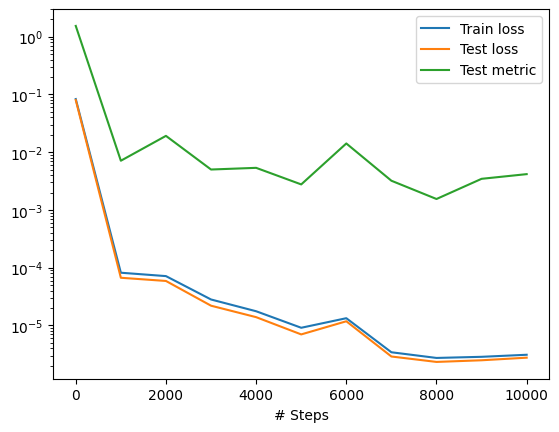

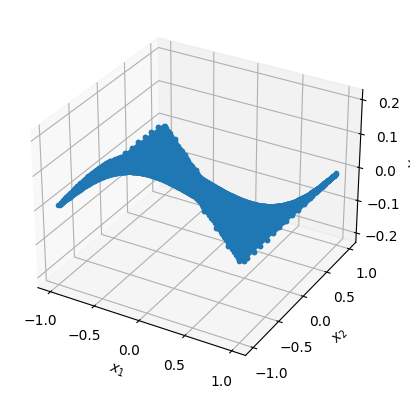

In [18]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [19]:
def diff_function(x):
    model_value = model.predict(x)
    true_value = psi_2d_rectangle(x)
    return model_value - true_value

In [20]:
diff_function(np.array([[0.0, 0.0], [1.0, 0.0]]))

array([[3.6722544e-05],
       [3.4371336e-04]], dtype=float32)

In [21]:
def plot_2d_map(plotted_function, grid_dist=0.01):
    x_ax = np.arange(-L, L, grid_dist)
    y_ax = np.arange(-L, L, grid_dist)
    grid_x, grid_y = np.meshgrid(x_ax, y_ax)
    
    diff_list = []
    for a, b in zip(grid_x, grid_y):
        pair_list = []
        for x, y in zip(a, b):
            pair_list.append([x, y])
        pairs = np.array(pair_list)
        diff_list.append(np.squeeze(plotted_function(pairs)))

    diff_list = np.array(diff_list)
    
    im = plt.imshow(diff_list, cmap=plt.cm.RdBu)
    plt.colorbar(im)

    plt.show()

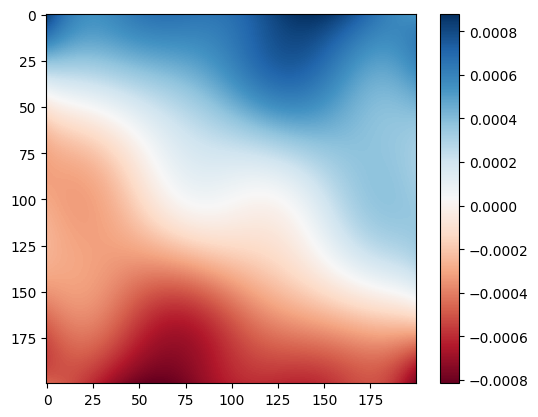

In [22]:
plot_2d_map(diff_function)

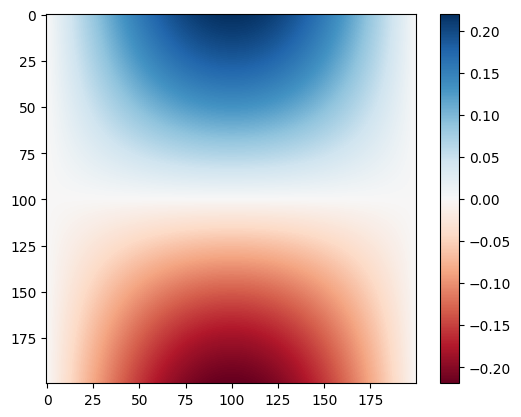

In [23]:
plot_2d_map(model.predict)

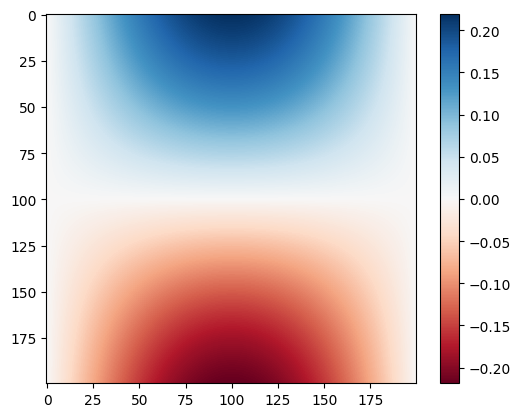

In [24]:
plot_2d_map(psi_2d_rectangle)